In [2]:
!nvidia-smi

Thu May 11 16:04:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti      On | 00000000:01:00.0 Off |                  N/A |
| 30%   40C    P8               24W / 310W|    530MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os

###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
###
from tqdm import tqdm
from sklearn.model_selection import train_test_split
#
from PIL import Image
#
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from torch import nn
###
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
#from transformers import AutoModel, AutoTokenizer
#from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

2023-05-11 16:04:50.957645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Dataset

## UCM Satellite 

In [4]:
import json

In [5]:
location = '../CLIP_demo/UCM_captions/dataset.json'
datasat = pd.read_json(location)
datasat.head()

,images,dataset
0,"{'sentids': [0, 1, 2, 3, 4], 'imgid': 0, 'sent...",UCM
1,"{'sentids': [5, 6, 7, 8, 9], 'imgid': 1, 'sent...",UCM
2,"{'sentids': [10, 11, 12, 13, 14], 'imgid': 2, ...",UCM
3,"{'sentids': [15, 16, 17, 18, 19], 'imgid': 3, ...",UCM
4,"{'sentids': [20, 21, 22, 23, 24], 'imgid': 4, ...",UCM


In [6]:
with open(location, 'r') as f:
    data = json.loads(f.read())
datasat_nest = pd.json_normalize(data, record_path=['images'])

In [7]:
datasat_nest.sentences[0]

[{'tokens': ['There', 'is', 'a', 'piece', 'of', 'formland'],
  'raw': 'There is a piece of farmland .',
  'imgid': 0,
  'sentid': 0},
 {'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'There is a piece of cropland .',
  'imgid': 0,
  'sentid': 1},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'It is a piece of farmland .',
  'imgid': 0,
  'sentid': 2},
 {'tokens': ['It', 'is', 'a', 'piece', 'of', 'cropland'],
  'raw': 'It is a piece of cropland .',
  'imgid': 0,
  'sentid': 3},
 {'tokens': ['Here', 'is', 'a', 'piece', 'of', 'farmland'],
  'raw': 'Here is a piece of farmland .',
  'imgid': 0,
  'sentid': 4}]

In [8]:
len(datasat_nest.sentences)

2100

In [9]:
datasat_nest.sentences[572]

[{'tokens': ['This', 'is', 'a', 'chaparral'],
  'raw': 'This is a chaparral .',
  'imgid': 572,
  'sentid': 2860},
 {'tokens': ['Lots', 'of', 'plants', 'scattered', 'on', 'the', 'ground.'],
  'raw': 'Lots of plants scattered on the ground. .',
  'imgid': 572,
  'sentid': 2861},
 {'tokens': ['Lots',
   'of',
   'plants',
   'scattered',
   'in',
   'the',
   'loess',
   'ground.'],
  'raw': 'Lots of plants scattered in the loess ground. .',
  'imgid': 572,
  'sentid': 2862},
 {'tokens': ['There',
   'are',
   'some',
   'grey',
   'plants',
   'scattered',
   'on',
   'the',
   'ground'],
  'raw': 'There are some grey plants scattered on the ground .',
  'imgid': 572,
  'sentid': 2863},
 {'tokens': ['Some',
   'grey',
   'plants',
   'are',
   'scattered',
   'in',
   'the',
   'loess',
   'ground'],
  'raw': 'Some grey plants are scattered in the loess ground .',
  'imgid': 572,
  'sentid': 2864}]

In [10]:
datasat_nest.sentences[1][1]

{'tokens': ['There', 'is', 'a', 'piece', 'of', 'cropland'],
 'raw': 'There is a piece of cropland .',
 'imgid': 1,
 'sentid': 6}

In [11]:
def create_record(location, image, caption):
    record = pd.DataFrame({
        'caption':caption, 
        'image':location+image
        }, index=[0])
    return record

In [12]:
satnet = pd.DataFrame(columns=['caption','image'])
location = '../CLIP_demo/UCM_captions/imgs/'
satnet.head()

,caption,image


In [13]:
for item in range(0, len(datasat_nest.sentences)):
    for child in range(0, len(datasat_nest.sentences[item])):
        record = create_record(
            location = location, 
            caption = str(datasat_nest.sentences[item][child]['raw']).lower(),
            image = str(datasat_nest.sentences[item][child]['imgid']+1)+'.jpeg'
        )
        satnet = pd.concat([satnet, record],ignore_index=True)
#datasat_nest.sentences[1][1]['raw']

In [14]:
satnet.tail()

,caption,image
10495,four tennis courts on the lawn with a road bes...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10496,four tennis courts are on the lawn and a road ...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10497,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10498,there are four tennis courts on the lawn and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg
10499,there are four tennis courts with a road and s...,../CLIP_demo/UCM_captions/imgs/2100.jpeg


In [15]:
satnet.dropna().to_csv('../CLIP_demo/dataset_sat.csv', index=False)

# Training

In [16]:
from transformers import TrainingArguments, AutoTokenizer, CLIPFeatureExtractor

In [17]:
#TEXT_MODEL = 'm3hrdadfi/roberta-zwnj-wnli-mean-tokens'
#TEXT_MODEL = 'bert-base-uncased'
#TEXT_MODEL = "roberta-base"
TEXT_MODEL = "bert-base-uncased"
#TEXT_MODEL = "openai/clip-vit-base-patch32"
#TEXT_MODEL = "openai/clip-vit-base-patch16"
#IMAGE_MODEL = "openai/clip-vit-large-patch14"
IMAGE_MODEL = 'openai/clip-vit-base-patch32'

In [18]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
MAX_LEN = 80
MEAN = torch.tensor([0.48424855, 0.49004773, 0.45052255]) #Image Mean
STD = torch.tensor([0.21794012, 0.20181401, 0.19642211]) #Image STD

In [19]:
from transformers import CLIPFeatureExtractor

In [20]:
vision_preprocessor = CLIPFeatureExtractor.from_pretrained(IMAGE_MODEL)

In [21]:
from transformers import CLIPTokenizer
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)
#tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [22]:
from clip_classes import CLIPDataset

In [23]:
args = TrainingArguments(
    output_dir="clip-checkpoints",
    evaluation_strategy="steps",
    save_strategy="epoch",
    eval_steps=500,
    logging_steps=10,
    learning_rate=3e-5,
    weight_decay=0.003,
    warmup_steps=100,
    fp16=False,
    prediction_loss_only=True,
    gradient_accumulation_steps=2, #1
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=20,
    report_to='none'
)

## Utils: some helper functions
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/utils.py

In [24]:
import helper

In [25]:
from clip_functions import clip_wrapper_creator

## DataModule: datasets and dataloaders
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/data.py

## Model: define vision and text encoder
https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/model.py

In [26]:
from transformers import CLIPTextModel

In [27]:
DATA_FILE = '../CLIP_demo/dataset_sat.csv'
TEST_SIZE = 0.05

In [28]:
from torch.utils.data import Dataset
class CLIPDataset(Dataset):
    def __init__(self, image_paths: list, text: list, mode: str = 'train'):
        self.image_paths = image_paths
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=MAX_LEN, truncation=True)

        if mode == 'train':
            self.augment = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])
        elif mode == 'test':
            self.augment = transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN, std=STD)
            ])

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask,
                'pixel_values': self.augment(Image.open(self.image_paths[idx]).convert('RGB'))}

    def __len__(self):
        return len(self.image_paths)

In [29]:
df = pd.read_csv(DATA_FILE)
train_df, test_df = train_test_split(df, test_size=TEST_SIZE)
train_ds = CLIPDataset(image_paths=train_df.image.tolist(),text=train_df.caption.tolist(), mode='train')
test_ds = CLIPDataset(image_paths=test_df.image.tolist(),text=test_df.caption.tolist(), mode='test')
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,collate_fn=default_data_collator)

In [30]:
def show_data(batch, idx=0):
    # show image
    img = batch['pixel_values'][idx].permute(1, 2, 0)
    img = STD * img + MEAN
    print('Image shape: ', img.shape)
    plt.imshow(img)
    # show text
    text = tokenizer.decode(batch['input_ids'][idx],  skip_special_tokens=True)
    print('Text: ', text)

torch.Size([8, 80])
torch.Size([8, 3, 224, 224])
Image shape:  torch.Size([224, 224, 3])
Text:  lots of boats docked at the harbor and the water is deep blue.


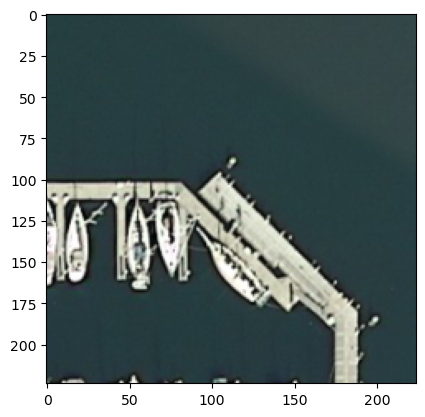

In [31]:
for item in train_dl:
    print(item['input_ids'].shape)
    print(item['pixel_values'].shape)
    break
show_data(item)

In [32]:
vision_encoder = CLIPVisionModel.from_pretrained(IMAGE_MODEL)
#config = CLIPConfig.from_pretrained("openai/clip-vit-base-patch16")
#vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16", config=config.vision_config)

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.5.layer_norm2.bias', 'text_model.encoder.layers.9.self_attn.k_proj.weight', 'text_model.encoder.layers.9.mlp.fc1.weight', 'text_model.encoder.layers.2.self_attn.k_proj.weight', 'text_model.encoder.layers.2.self_attn.v_proj.weight', 'text_model.encoder.layers.7.mlp.fc1.weight', 'text_model.encoder.layers.9.self_attn.v_proj.bias', 'text_model.encoder.layers.4.self_attn.k_proj.weight', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.q_proj.weight', 'text_model.encoder.layers.4.self_attn.out_proj.bias', 'text_model.encoder.layers.10.self_attn.q_proj.bias', 'text_model.encoder.layers.9.self_attn.q_proj.bias', 'text_model.encoder.layers.6.mlp.fc2.bias', 'text_model.encoder.layers.11.layer_norm2.bias', 'text_model.encoder.layers.10.layer_norm2.bias', 'te

In [33]:
text_encoder = CLIPTextModel.from_pretrained(TEXT_MODEL)
#text_encoder = BertModel.from_pretrained("bert-base-uncased")

You are using a model of type bert to instantiate a model of type clip_text_model. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing CLIPTextModel: ['bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.5.intermediate.dense.bias', 'bert.encoder.layer.6.attention.output.dense.weight', 'bert.encoder.layer.2.attention.self.key.weight', 'bert.encoder.layer.3.intermediate.dense.bias', 'bert.encoder.layer.3.attention.output.dense.bias', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.self.value.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.2.output.dense.weight', 'bert.encoder.layer.8.output.LayerNorm.bias', 'bert.encoder.layer.9.output.dense.weight', 'bert.encoder.layer.5.output.dense.weight', 'bert.encoder.layer.3.attention.self.query.weight', 'bert.encoder.layer.7.attention.output.LayerNorm.bias', 

In [34]:
def clip_wrapper_creator():
    """create a dummy CLIPModel to wrap text and vision encoders in order to use CLIPTrainer"""
    config = {'num_hidden_layers': 0,
              'max_position_embeddings': 0,
              'vocab_size': 0,
              'hidden_size': 1,
              'patch_size': 1,
              }

    #DUMMY_CONFIG = CLIPConfig(text_config_dict=config,vision_config_dict=config)
    DUMMY_CONFIG = CLIPConfig(
        text_config_dict = config,
        vision_config_dict = config
    )

    clip = CLIPModel(config=DUMMY_CONFIG)

    # convert projectors to Identity
    clip.text_projection = nn.Identity()
    clip.visual_projection = nn.Identity()

    return clip


In [35]:
#text_encoder = AutoModel.from_pretrained(TEXT_MODEL)
#text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-base-patch32')

clip = clip_wrapper_creator()
clip.text_model = text_encoder
clip.vision_model = vision_encoder

In [36]:
text_encoder.config.hidden_size

768

In [37]:
vision_encoder.config.hidden_size

768

In [38]:
assert text_encoder.config.hidden_size == vision_encoder.config.hidden_size

In [39]:
if __name__ == '__main__':
    out = clip(input_ids=item['input_ids'],
               attention_mask=item['attention_mask'],
               pixel_values=item['pixel_values'],
               return_loss=True)

    print('text and image embeddings: ',
          out.text_embeds.shape, out.image_embeds.shape)
    print('loss: ', out.loss)
    del out, item

text and image embeddings:  torch.Size([8, 768]) torch.Size([8, 768])
loss:  tensor(2.2229, grad_fn=<DivBackward0>)


## Trainer: train using huggingface trainer
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/training/train.py

In [40]:
from clip_classes import CLIPTrainer

In [41]:
def train_model():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    helper.clear_gpu()
    args.dataloader_num_workers = helper.optimal_workers()
    trainer = CLIPTrainer(clip, args,
                          train_dataset=train_ds,
                          eval_dataset=test_ds)

    trainer.train()

train_model()

    # save pretrained models
    # clip.text_model.save_pretrained('radCLIP')
    # tokenizer.save_pretrained('radCLIP')
    # clip.vision_model.save_pretrained('radCLIP')
    # vision_preprocessor.save_pretrained('radCLIP')

/home/andrew/miniconda3/envs/CLIP_demo/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9975
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 12460
  Number of trainable parameters = 196346113


Step,Training Loss,Validation Loss
500,0.294700,0.353672
1000,0.439800,0.335399
1500,0.387500,0.301269
2000,0.234100,0.310746
2500,0.205000,0.249136
3000,0.224400,0.274264
3500,0.268800,0.261406
4000,0.254300,0.231472
4500,0.194700,0.227964
5000,0.233600,0.222558


***** Running Evaluation *****
  Num examples = 525
  Batch size = 8
Saving model checkpoint to clip-checkpoints/checkpoint-623
Configuration saved in clip-checkpoints/checkpoint-623/config.json
Model weights saved in clip-checkpoints/checkpoint-623/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 525
  Batch size = 8
Saving model checkpoint to clip-checkpoints/checkpoint-1246
Configuration saved in clip-checkpoints/checkpoint-1246/config.json
Model weights saved in clip-checkpoints/checkpoint-1246/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 525
  Batch size = 8
Saving model checkpoint to clip-checkpoints/checkpoint-1869
Configuration saved in clip-checkpoints/checkpoint-1869/config.json
Model weights saved in clip-checkpoints/checkpoint-1869/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 525
  Batch size = 8
Saving model checkpoint to clip-checkpoints/checkpoint-2492
Configuration saved in clip-checkpoints/checkpoint-2492/confi

# Demo

## Utils: demo utils
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/utils.py

In [42]:
class VisionDataset(Dataset):
    preprocess = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=MEAN, std=STD)
    ])

    def __init__(self, image_paths: list):
        self.image_paths = image_paths

    def __getitem__(self, idx):
        return self.preprocess(Image.open(self.image_paths[idx]).convert('RGB'))

    def __len__(self):
        return len(self.image_paths)


class TextDataset(Dataset):
    def __init__(self, text: list, tokenizer, max_len):
        self.len = len(text)
        self.tokens = tokenizer(text, padding='max_length',
                                max_length=max_len, truncation=True)

    def __getitem__(self, idx):
        token = self.tokens[idx]
        return {'input_ids': token.ids, 'attention_mask': token.attention_mask}

    def __len__(self):
        return self.len

## CLIPDemo
- https://github.com/sajjjadayobi/CLIPfa/blob/main/clipfa/application/main.py

In [43]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import default_data_collator


class CLIPDemo:
    def __init__(self, vision_encoder, text_encoder, tokenizer,
                 batch_size: int = 32, max_len: int = 32, device='cuda'):
        """ Initializes CLIPDemo
            it has the following functionalities:
                image_search: Search images based on text query
                zero_shot: Zero shot image classification
                analogy: Analogies with embedding space arithmetic.

            Args:
            vision_encoder: Fine-tuned vision encoder
            text_encoder: Fine-tuned text encoder
            tokenizer: Transformers tokenizer
            device (torch.device): Running device
            batch_size (int): Size of mini-batches used to embeddings
            max_length (int): Tokenizer max length

            Example:
            >>> demo = CLIPDemo(vision_encoder, text_encoder, tokenizer)
            >>> demo.compute_image_embeddings(test_df.image.to_list())
            >>> demo.image_search('یک مرد و یک زن')
            >>> demo.zero_shot('./workers.jpg')
            >>> demo.anology('./sunset.jpg', additional_text='دریا')
        """
        self.vision_encoder = vision_encoder.eval().to(device)
        self.text_encoder = text_encoder.eval().to(device)
        self.batch_size = batch_size
        self.device = device
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.text_embeddings_ = None
        self.image_embeddings_ = None
        

    def compute_image_embeddings(self, image_paths: list):
        self.image_paths = image_paths
        datalodear = DataLoader(VisionDataset(
            image_paths=image_paths), batch_size=self.batch_size)
        embeddings = []
        with torch.no_grad():
            for images in tqdm(datalodear, desc='computing image embeddings'):
                image_embedding = self.vision_encoder(
                    pixel_values=images.to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.image_embeddings_ =  torch.cat(embeddings)

    def compute_text_embeddings(self, text: list):
        self.text = text
        dataloader = DataLoader(TextDataset(text=text, tokenizer=self.tokenizer, max_len=self.max_len),
                                batch_size=self.batch_size, collate_fn=default_data_collator)
        embeddings = []
        with torch.no_grad():
            for tokens in tqdm(dataloader, desc='computing text embeddings'):
                image_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                                    attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
                embeddings.append(image_embedding)
        self.text_embeddings_ = torch.cat(embeddings)

    def text_query_embedding(self, query: str = ''):
        tokens = self.tokenizer(query, return_tensors='pt')
        with torch.no_grad():
            text_embedding = self.text_encoder(input_ids=tokens["input_ids"].to(self.device),
                                               attention_mask=tokens["attention_mask"].to(self.device)).pooler_output
        return text_embedding

    def image_query_embedding(self, image):
        image = VisionDataset.preprocess(image).unsqueeze(0)
        with torch.no_grad():
            image_embedding = self.vision_encoder(
                image.to(self.device)).pooler_output
        return image_embedding

    def most_similars(self, embeddings_1, embeddings_2):
        values, indices = torch.cosine_similarity(
            embeddings_1, embeddings_2).sort(descending=True)
        return values.cpu(), indices.cpu()

    def zero_shot(self, image_path: str):
        """ Zero shot image classification with label list 
            Args:
                image_path (str): target image path that is going to be classified
                class_list (list[str]): list of candidate classes 
        """
        image = Image.open(image_path)
        image_embedding = self.image_query_embedding(image)
        values, indices = self.most_similars(image_embedding, self.text_embeddings_)
        for i, sim in zip(indices, torch.softmax(values, dim=0)):
            print(
                f'label: {self.text[i]} | {round(float(sim), 3)}')
        plt.imshow(image)
        plt.axis('off')

    def image_search(self, query: str, top_k=25):
        """ Search images based on text query
            Args:
                query (str): text query 
                image_paths (list[str]): a bunch of image paths
                top_k (int): number of relevant images 
        """
        query_embedding = self.text_query_embedding(query=query)
        _, indices = self.most_similars(self.image_embeddings_, query_embedding)

        matches = np.array(self.image_paths)[indices][:top_k]
        _, axes = plt.subplots(2, int(top_k/2), figsize=(15, 5))
        for match, ax in zip(matches, axes.flatten()):
            ax.imshow(Image.open(match).resize((224, 224)))
            ax.axis("off")
        plt.show()

    def analogy(self, input_image_path: str, additional_text: str = '', input_include=True):
        """ Analogies with embedding space arithmetic.
            Args:
                input_image_path (str): The path to original image 
                image_paths (list[str]): A database of images
        """
        base_image = Image.open(input_image_path)
        image_embedding = self.image_query_embedding(base_image)
        additional_embedding = self.text_query_embedding(query=additional_text)
        new_image_embedding = image_embedding + additional_embedding
        _, indices = self.most_similars(
            self.image_embeddings_, new_image_embedding)

        new_image = Image.open(self.image_paths[indices[1 if input_include else 0]])
        _, ax = plt.subplots(1, 2, dpi=100)
        ax[0].imshow(base_image.resize((250, 250)))
        ax[0].set_title('original image')
        ax[0].axis('off')
        ax[1].imshow(new_image.resize((250, 250)))
        ax[1].set_title('new image')
        ax[1].axis('off')

In [65]:
search = CLIPDemo(vision_encoder, text_encoder, tokenizer)
search.compute_image_embeddings(test_df.image.to_list())
search.compute_text_embeddings(['ocean','water', 'tennis', 'tennis court', 'baseball', 'sand', 'house', 'river'])

computing text embeddings: 100%|██████████████████| 1/1 [00:00<00:00, 78.47it/s]


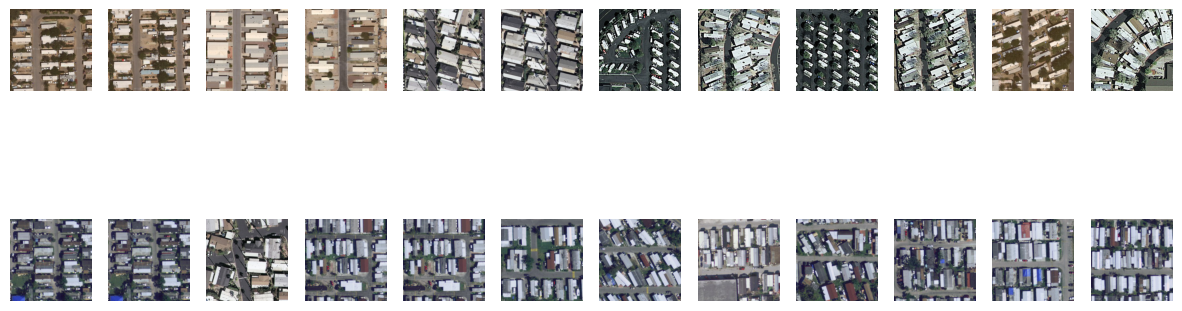

In [70]:
search.image_search('tennis')

label: tennis | 0.136
label: tennis court | 0.136
label: river | 0.13
label: house | 0.126
label: water | 0.122
label: sand | 0.117
label: ocean | 0.117
label: baseball | 0.116


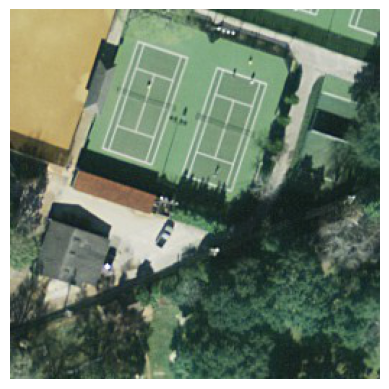

In [67]:
search.zero_shot(f'{location}/2036.jpeg')

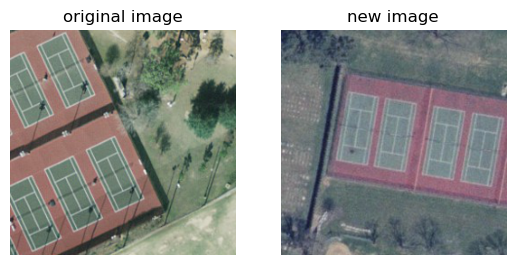

In [69]:
search.analogy(f'{location}/2028.jpeg')